In [22]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

import numpy as np
from somJ.som import SoM
from somJ.utils import plot_map
import somJ.config as config
from somJ.clustering import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

In [23]:
iris=load_iris()
data=iris.data
y_true=iris.target
n_clusters = np.unique(y_true).size

In [24]:
som = SoM(
    #method='pca',
    input_dim=data.shape[1],
    data=data,
    total_nodes=config.TOTAL_NODES
)
som.train(
    train_data=data,
    learn_rate=config.LEARNING_RATE,
    radius_sq=config.RADIUS_SQ,
    lr_decay=config.LR_DECAY,
    radius_decay=config.RADIUS_DECAY,
    epochs=config.EPOCHS,
    update="online",
    batch_size=config.BATCH_SIZE,
    step=config.STEP,
    save=config.SAVE_HISTORY
)
groups, _ = som_clustering(som.som_map, n_clusters)
bmu_coords = np.array([som.find_winner(x) for x in data])


Dimensiones del SOM: m = 16, n = 6
SOM inicializado aleatoriamente.


In [25]:
cluster_map = np.full(som.som_map.shape[:2], -1, dtype=int)  # solo usa (m, n)

for cluster_id, nodes in groups.items():
    for i, j in nodes:
        cluster_map[i, j] = cluster_id

rows, cols = cluster_map.shape

for cluster_id, nodes in groups.items():
    for i, j in nodes:
        cluster_map[i, j] = cluster_id

In [26]:
cluster_map

array([[ 0,  1,  1,  1,  1,  1],
       [ 0,  1,  1,  1,  1,  1],
       [ 0,  0,  1,  1,  1,  1],
       [ 0,  0,  1,  1,  1,  1],
       [ 0,  0,  0,  1,  1,  1],
       [ 0,  0,  0,  0,  1,  1],
       [ 0,  0,  0, 39, 39, 39],
       [ 0,  0, 39, 39, 39, 39],
       [ 0,  0, 39, 39, 39, 39],
       [ 0,  0,  0, 39, 39, 39],
       [ 0,  0,  0, 39, 39, 39],
       [ 0,  0,  0,  0, 39, 39],
       [ 0,  0,  0,  0,  0, 39],
       [ 0,  0,  0,  0, 39, 39],
       [ 0,  0,  0,  0, 39, 39],
       [ 0,  0,  0,  0, 39, 39]])

In [27]:
cluster_ids = np.array([ cluster_map[i, j] 
                         for (i, j) in bmu_coords ])
                         

In [32]:
from collections import Counter

label_map = {}
for k in np.unique(cluster_ids):
    mask = (cluster_ids == k)
    most_common = Counter(y_true[mask]).most_common(1)[0][0]
    label_map[k] = most_common

# Ahora traducimos cada cluster_id a una etiqueta “predicha”:
y_pred_majority = np.array([ label_map[k] for k in cluster_ids ])


 Accuracy: 88.67%


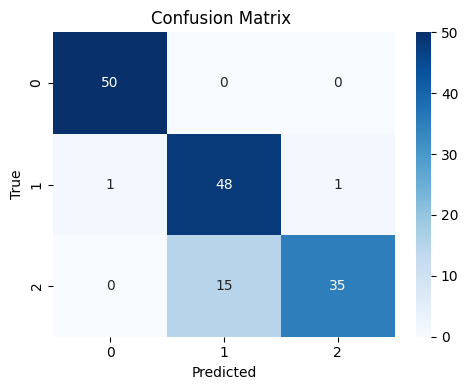

In [40]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

accuracy = accuracy_score(y_true, y_pred_majority)
cm = confusion_matrix(y_true, y_pred_majority)

print(f" Accuracy: {accuracy:.2%}")
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix ")
plt.tight_layout()
plt.show()


Dimensiones del SOM: m = 16, n = 6
SOM inicializado aleatoriamente.
Dimensiones del SOM: m = 16, n = 6
SOM inicializado aleatoriamente.
Dimensiones del SOM: m = 16, n = 6
SOM inicializado aleatoriamente.
Dimensiones del SOM: m = 16, n = 6
SOM inicializado usando PCA.
Dimensiones del SOM: m = 16, n = 6
SOM inicializado usando PCA.
Dimensiones del SOM: m = 16, n = 6
SOM inicializado usando PCA.


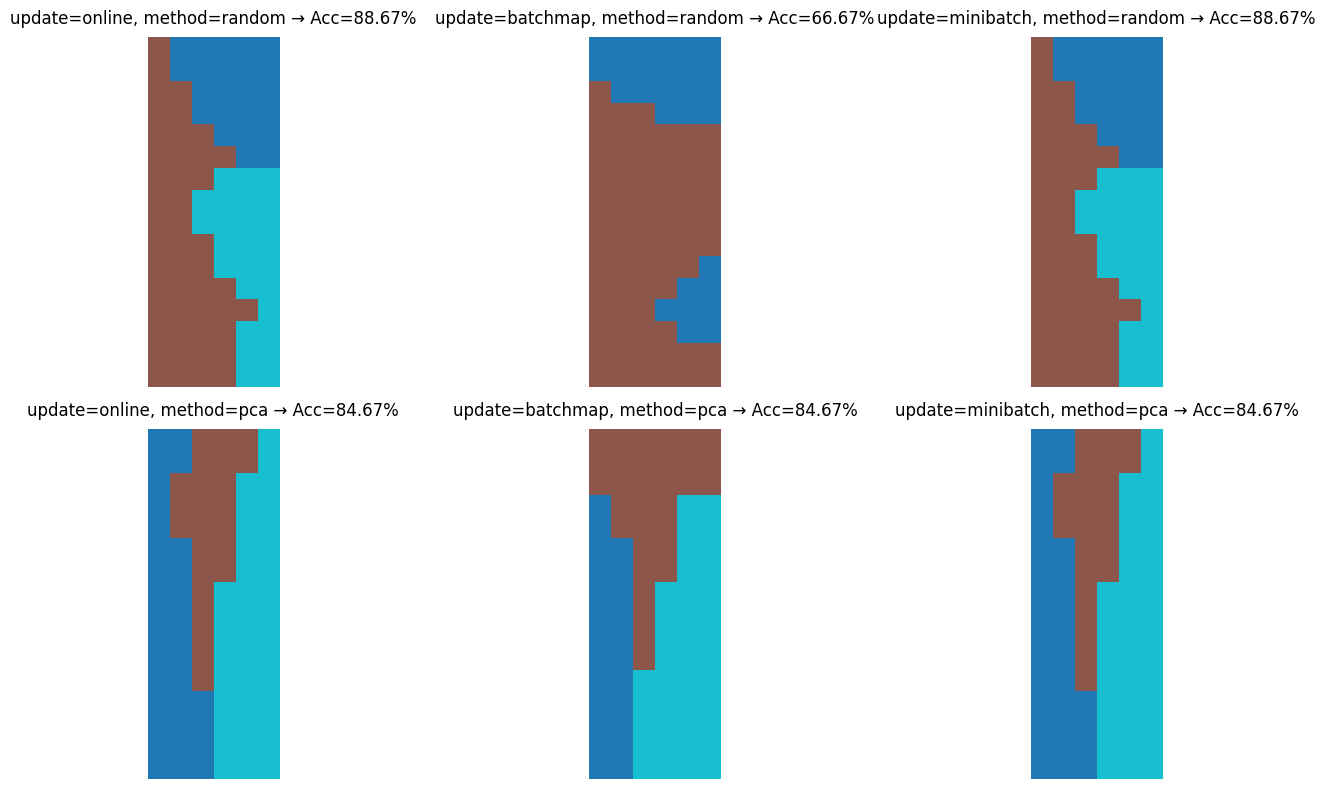

In [52]:
# %%
from sklearn.metrics import accuracy_score
from collections import Counter
import matplotlib.pyplot as plt

updates = ["online", "batchmap", "minibatch"]
methods_order = ["random", "pca"]  # fila 0 → random; fila 1 → pca

fig, axes = plt.subplots(2, 3, figsize=(16, 8))

for row, mtd in enumerate(methods_order):
    for col, upd in enumerate(updates):
        ax = axes[row, col]

        # 1) Entrena el SOM con esta combinación
        som = SoM(
            method=mtd,
            input_dim=data.shape[1],
            data=data,
            total_nodes=config.TOTAL_NODES
        )
        som.train(
            train_data=data,
            learn_rate=config.LEARNING_RATE,
            radius_sq=config.RADIUS_SQ,
            lr_decay=config.LR_DECAY,
            radius_decay=config.RADIUS_DECAY,
            epochs=config.EPOCHS,
            update=upd,
            batch_size=config.BATCH_SIZE,
            step=config.STEP,
            save=config.SAVE_HISTORY
        )

        # 2) Clustering y BMU
        groups, _ = som_clustering(som.som_map, n_clusters)
        bmu_coords = np.array([som.find_winner(x) for x in data])

        # 3) Construye el cluster_map
        cluster_map = np.full(som.som_map.shape[:2], -1, dtype=int)
        for cid, nodes in groups.items():
            for (i, j) in nodes:
                cluster_map[i, j] = cid

        # 4) Etiquetado por mayoría
        cluster_ids = np.array([cluster_map[i, j] for (i, j) in bmu_coords])
        label_map = {}
        for cid in groups.keys():
            mask = (cluster_ids == cid)
            if np.any(mask):
                label_map[cid] = Counter(y_true[mask]).most_common(1)[0][0]

        # 5) Mapa de etiquetas predichas por nodo
        predicted_label_map = np.full_like(cluster_map, -1)
        for cid, nodes in groups.items():
            for (i, j) in nodes:
                predicted_label_map[i, j] = label_map.get(cid, -1)

        # 6) Calcula accuracy
        y_pred = np.array([label_map.get(cluster_map[i, j], -1) for (i, j) in bmu_coords])
        acc = accuracy_score(y_true, y_pred)

        # 7) Dibuja en el subplot correcto
        plt.sca(ax)
        im = ax.imshow(predicted_label_map, cmap='tab10', vmin=0, vmax=n_clusters-1)
        ax.axis("off")
        ax.set_title(f"update={upd}, method={mtd} → Acc={acc:.2%}", pad=10)


plt.tight_layout()
plt.show()
